# Mount Google Drive to Google Colab

In [94]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Libraries

In [95]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

# Create Train and Validation Set

In [96]:
data_dir = "/content/drive/MyDrive/Gladies_VA_Plants"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_ds = image_generator.flow_from_directory(batch_size=32,
                                                 directory= data_dir,
                                                 shuffle=True,
                                                 target_size=(280, 280), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_ds = image_generator.flow_from_directory(batch_size=32,
                                                 directory= data_dir,
                                                 shuffle=True,
                                                 target_size=(280, 280), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 192 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [97]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

In [98]:
# https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/ 

In [99]:
import glob
Arrowhead = glob.glob('/content/drive/MyDrive/Gladies_VA_Plants/Arrowhead/*.*')
Duckweed = glob.glob('/content/drive/MyDrive/Gladies_VA_Plants/Duckweed/*.*')
Grassy_Mud_Plaintain= glob.glob('/content/drive/MyDrive/Gladies_VA_Plants/Grassy Mud Plaintain/*.*')
Hydrilla = glob.glob('/content/drive/MyDrive/Gladies_VA_Plants/Hydrilla/*.*')
Watercress = glob.glob('/content/drive/MyDrive/Gladies_VA_Plants/Watercress/*.*')

data = []
labels = []

for i in Arrowhead:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in Duckweed:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in Grassy_Mud_Plaintain:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in Hydrilla:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(3)
for i in Watercress:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(4)    

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

In [100]:
X_train.shape

(189, 224, 224, 3)

In [101]:
y_train.shape

(189,)

In [102]:
X_test.shape

(48, 224, 224, 3)

In [103]:
num_classes = 5
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [104]:
X_train.shape

(189, 224, 224, 3)

In [105]:
y_train.shape

(189, 5)

In [106]:
X_test.shape

(48, 224, 224, 3)

In [107]:
y_test.shape

(48, 5)

# Inception

In [108]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [109]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [110]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(5, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(5, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(5, activation='softmax', name='output')(x)

In [111]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [112]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [113]:
epochs = 600
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [114]:
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32, callbacks=[lr_sc])

# Data Augmentation

In [115]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [116]:
datagen.fit(X_train)

In [117]:
datagen.fit(X_test)

In [118]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32, callbacks=[lr_sc])

Epoch 1/600

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
6/6 [==============================] - 4s 272ms/step - loss: 13.0448 - output_loss: 7.4260 - auxilliary_output_1_loss: 14.0210 - auxilliary_output_2_loss: 4.7084 - output_accuracy: 0.2349 - auxilliary_output_1_accuracy: 0.2581 - auxilliary_output_2_accuracy: 0.2693 - val_loss: 3.2161 - val_output_loss: 1.9839 - val_auxilliary_output_1_loss: 2.6883 - val_auxilliary_output_2_loss: 1.4191 - val_output_accuracy: 0.3542 - val_auxilliary_output_1_accuracy: 0.3542 - val_auxilliary_output_2_accuracy: 0.3542
Epoch 2/600

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
6/6 [==============================] - 1s 128ms/step - loss: 3.5348 - output_loss: 2.3860 - auxilliary_output_1_loss: 2.2718 - auxilliary_output_2_loss: 1.5578 - output_accuracy: 0.3058 - auxilliary_output_1_accuracy: 0.2753 - auxilliary_output_2_accuracy: 0.2949 - val_loss: 2.2908 - val_output_loss: 1.4301 - val_auxilliary_output_1_

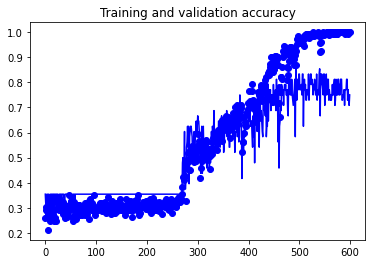

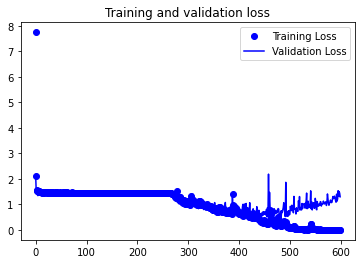

In [119]:
import matplotlib.pyplot as plt
acc = history.history['output_accuracy']
val_acc = history.history['val_output_accuracy']
loss = history.history['output_loss']
val_loss = history.history['val_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()